© Steadforce GmbH 2020

#0. Get dependencies and the pretrained model

# 1. Import all modules

In [1]:
!pip install shap
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.
/data/ephemeral/home/khk/level2-objectdetection-cv-09/XAI/yolov5


In [2]:
import json
import random
import torch
import torch.backends.cudnn as cudnn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shap
import cv2
from utils.general import non_max_suppression, box_iou
from ultralytics import YOLO
device = torch.device('cuda:0')

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Load and prepare the image with detected object

In [3]:
img_size = 640
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img_org = cv2.imread("../../dataset/train/1516.jpg", cv2.IMREAD_COLOR)
#img_org = cv2.imread("data/images/false_positive.jpg", cv2.IMREAD_COLOR)
img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
old_img_size = img_org.shape[:2] # old size is in (height, width) format
ratio = float(img_size)/max(old_img_size)
new_size_y, new_size_x = tuple([int(x*ratio) for x in old_img_size])
img = cv2.resize(img_org, (new_size_x, new_size_y))
img = img.astype("float64")/255


# 3. Load model and perform inference on the image

In [4]:
model = YOLO("../bests_re.pt")
confidence = 0.5
iou = 0.5
torch_image = torch.from_numpy(np.ascontiguousarray(img.transpose(2, 0, 1))).to(device).unsqueeze(0).half()
results = model(torch_image)
output = [0]
output[0] = results[0].boxes.data


0: 640x640 1 Paper, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


# 4. Implement adapter functions as NN layers

In [5]:
class CastNumpy(torch.nn.Module):
  def __init__(self):
    super(CastNumpy, self).__init__()

  def forward(self, image):
    """
    In the forward function we accept the inputs and cast them to a pytorch tensor
    """

    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image).to(device)
    if image.ndimension() == 3:
      image = image.unsqueeze(0)
    image_half = image.half()

    return image_half
  
numpy2torch_converter = CastNumpy()
numpy2torch_converter.forward(img.transpose(2, 0, 1))

tensor([[[[0.67822, 0.62744, 0.70605,  ..., 0.34912, 0.37256, 0.53320],
          [0.52930, 0.64697, 0.67041,  ..., 0.25488, 0.25488, 0.41187],
          [0.47852, 0.52148, 0.71387,  ..., 0.39209, 0.58447, 0.41577],
          ...,
          [0.57275, 0.55664, 0.51367,  ..., 0.63135, 0.56055, 0.37256],
          [0.55273, 0.63135, 0.49023,  ..., 0.37256, 0.48633, 0.37256],
          [0.57275, 0.56885, 0.37646,  ..., 0.43921, 0.32544, 0.34106]],

         [[0.65869, 0.60791, 0.69434,  ..., 0.35303, 0.37256, 0.53711],
          [0.52148, 0.63525, 0.66260,  ..., 0.25879, 0.25879, 0.41577],
          [0.47461, 0.51758, 0.70996,  ..., 0.39600, 0.58838, 0.41968],
          ...,
          [0.57275, 0.55664, 0.51367,  ..., 0.62744, 0.55664, 0.36865],
          [0.55273, 0.63135, 0.49023,  ..., 0.36865, 0.48242, 0.36865],
          [0.57275, 0.56885, 0.37646,  ..., 0.43530, 0.32153, 0.33716]],

         [[0.68604, 0.63135, 0.71777,  ..., 0.36865, 0.39209, 0.55273],
          [0.54102, 0.65869, 0

In [6]:
class OD2Score(torch.nn.Module):
    def __init__(self, target, conf_thresh=0.01, iou_thresh=0.5):
        """
        constructor
        """
        super(OD2Score, self).__init__()
        self.conf_thresh = conf_thresh
        self.iou_thresh = iou_thresh
        self.target = torch.tensor(target, device=device)

    def forward(self, x):
        """
        In the forward function we accept the predictions and return the score for a selected target of the box
        """
        score_best_box = torch.zeros(len(x), device=device)

        for idx, img in enumerate(x):
          output = [0]
          output[0] = img.boxes.data
          if output is not None:
            correct_class_predictions = output[0][...,5] == self.target[5]
            correctly_labeled_boxes = output[0][correct_class_predictions]

            if correctly_labeled_boxes.shape[0]:
              iou_with_target, _idx = box_iou(correctly_labeled_boxes[:,:4], self.target.unsqueeze(0)[:,:4]).max(1)
              index_best_box_in_correct_class = torch.argmax(iou_with_target)
              index_best_box_in_output = torch.where(output[0][...,5] == self.target[5])[0][index_best_box_in_correct_class]

              # score for the detection is the score from the prediction steps times intersection with expected position: (object score x class score) x iou_with_target

              # classification score
              #score_best_box[idx] = output[0][index_best_box_in_output][4]
              # position score
              #score_best_box[idx] = iou_with_target[index_best_box_in_correct_class]
              # both
              score_best_box[idx] = output[0][index_best_box_in_output][4]*iou_with_target[index_best_box_in_correct_class]

        return score_best_box.cpu().numpy()

# look at the image output above and set the index of the object you want to analyze here
target_index = 0
target = output[0].cpu().numpy()[target_index,:]
scoring = OD2Score(target, conf_thresh=confidence, iou_thresh=iou)

In [7]:
class SuperPixler(torch.nn.Module):
  def __init__(self, image, super_pixel_width):
    super(SuperPixler, self).__init__()

    self.image = image.transpose(2, 0, 1) # model expects images in BRG, not RGB, so transpose color channels
    self.mean_color = self.image.mean()
    self.image = np.expand_dims(self.image, axis=0)
    self.image_width = image.shape[1]
    self.super_pixel_width = super_pixel_width


  def forward(self, x):
    """
    In the forward step we accept the super pixel masks and transform them to a batch of images
    """

    pixeled_image = np.repeat(self.image.copy(), x.shape[0], axis=0)

    for i, super_pixel in enumerate(x.T):
      images_to_pixelate = [bool(p) for p in super_pixel]
      x = (i*self.super_pixel_width//self.image_width)*self.super_pixel_width
      y = i*self.super_pixel_width%self.image_width
      pixeled_image[images_to_pixelate,:,x:x+self.super_pixel_width, y:y+self.super_pixel_width] = self.mean_color

    return pixeled_image

super_pixel_width = 20
assert (img_size/super_pixel_width)%1 == 0, "image width needs to be multiple of super pixel width"
n_super_pixel = int((img.shape[1]/super_pixel_width)**2)

super_pixler = SuperPixler(img, super_pixel_width = super_pixel_width)

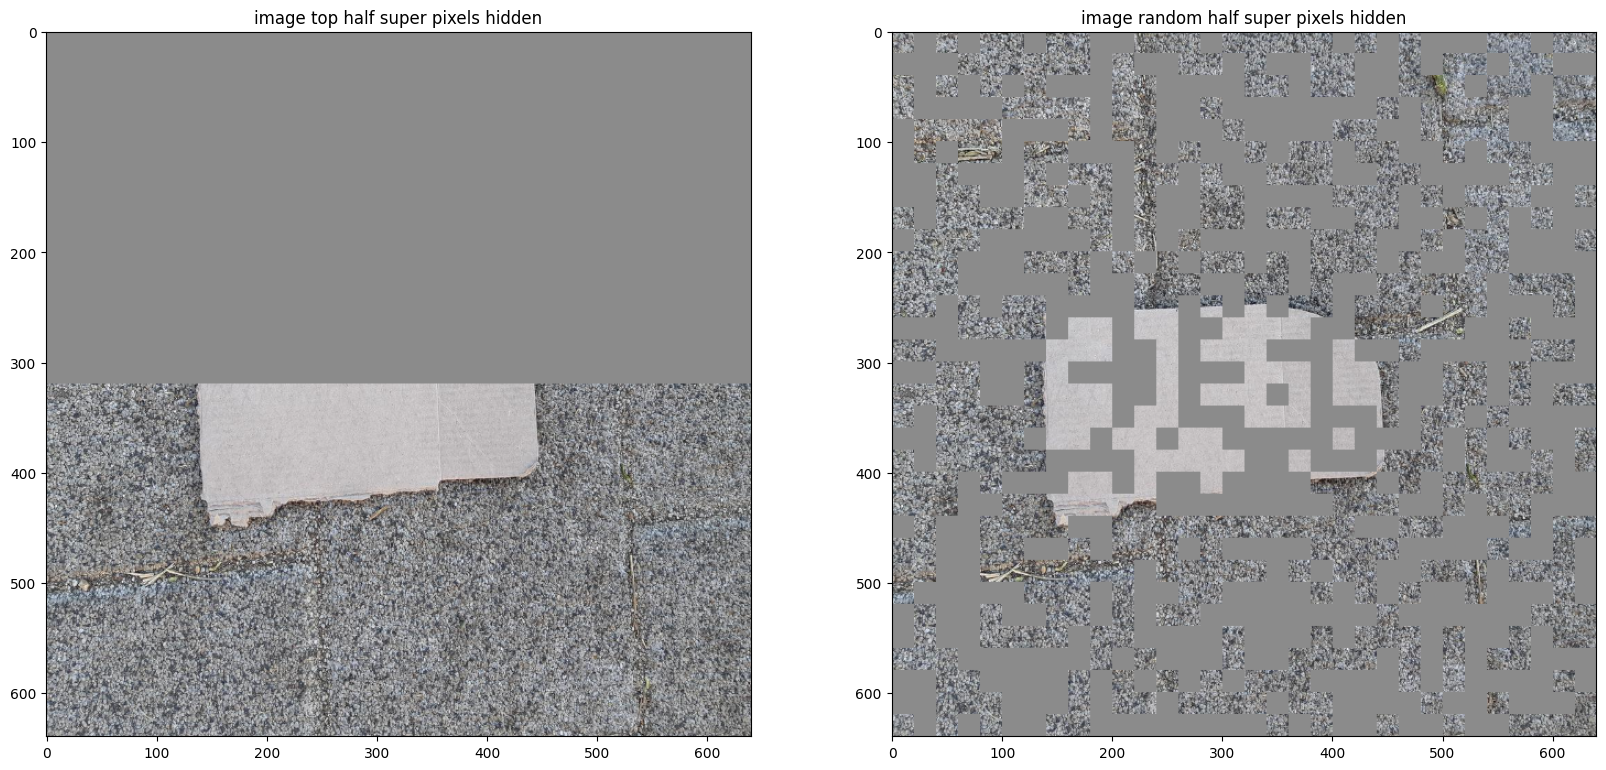

In [8]:
img_s = super_pixler.forward(np.array([[1 for _ in range(n_super_pixel//2)]+[0 for _ in range(n_super_pixel//2)],
                                       [random.randint(0,1) for _ in range(n_super_pixel)]]))
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("image top half super pixels hidden")
ax1.imshow(img_s[0,:,:,:].transpose(1,2,0))
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("image random half super pixels hidden")
ax2.imshow(img_s[1,:,:,:].transpose(1,2,0))
plt.show()

In [9]:
super_pixel_model = torch.nn.Sequential(
    super_pixler,
    numpy2torch_converter,
    model,
    scoring
)

# 5. Calculate SHAP values for patches of the image

In [10]:
# use Kernel SHAP to explain the detection

background_super_pixel = np.array([[1 for _ in range(n_super_pixel)]])
image_super_pixel = np.array([[0 for _ in range(n_super_pixel)]])
kernel_explainer = shap.KernelExplainer(super_pixel_model, background_super_pixel)

# Very large values for nsamples cause OOM errors depending on image and super pixel parameter. We combine batches of SHAP values to distribute the load.
collected_shap_values = np.zeros_like(background_super_pixel)
b = 100
for i in range(b):
  print(f"{i/b:0.2%}")

  shap_values = kernel_explainer.shap_values(image_super_pixel, nsamples=600)

  # take shap value with highest abs. value for each pixel from each batch
  stacked_values = np.vstack([shap_values, collected_shap_values])
  index_max_values = np.argmax(np.abs(stacked_values), axis=0)
  collected_shap_values = stacked_values[index_max_values, range(shap_values.shape[1])]
print((collected_shap_values!=0).sum(), "non-zero shap values found")

# plot the found SHAP values. Expected value does not match due to merging of batches
shap.initjs()
shap.force_plot(kernel_explainer.expected_value, collected_shap_values)


0: 640x640 (no detections), 12.8ms
Speed: 0.1ms preprocess, 12.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
0.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 12.6ms
Speed: 0.1ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 4 Papers, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Paper, 2.4ms
30: 640x640 1 Paper, 2.4ms
31: 640x640 1 Paper, 2.4ms
32: 640x640 (no detections), 2.4ms
33: 640x640 1 Paper, 2.4ms
34: 640x64

100%|██████████| 1/1 [00:09<00:00,  9.04s/it]


1.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.7ms
Speed: 0.1ms preprocess, 13.7ms inference, 27.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper pack, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x640 (no

100%|██████████| 1/1 [00:09<00:00,  9.06s/it]


2.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.5ms
Speed: 0.1ms preprocess, 14.5ms inference, 27.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper pack, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Pa

100%|██████████| 1/1 [00:09<00:00,  9.48s/it]


3.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.9ms
Speed: 0.1ms preprocess, 13.9ms inference, 27.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 (no detections), 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 (no detections), 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 (no detections), 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Paper, 2.4ms
30: 640

100%|██████████| 1/1 [00:09<00:00,  9.10s/it]


4.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.5ms
Speed: 0.1ms preprocess, 14.5ms inference, 29.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 2 Papers, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 2 Papers, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 2 Papers, 2.4ms
20: 640x640 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 1 Paper pack, 2.4ms
25: 640x640 2 Papers, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 (no detections), 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x640 1

100%|██████████| 1/1 [00:09<00:00,  9.05s/it]


5.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.2ms
Speed: 0.1ms preprocess, 13.2ms inference, 28.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 1 Paper pack, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper pack, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 3 Papers, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 2 Papers, 2.4ms
20: 640x640 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 2 Papers, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Paper, 2.4m

100%|██████████| 1/1 [00:09<00:00,  9.32s/it]


6.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.6ms
Speed: 0.1ms preprocess, 13.6ms inference, 27.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 4 Papers, 2.4ms
20: 640x640 1 Paper, 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 1 Paper pack, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 

100%|██████████| 1/1 [00:09<00:00,  9.26s/it]


7.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.0ms
Speed: 1.3ms preprocess, 14.0ms inference, 28.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper pack, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 (no detections), 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x640 1 Paper, 2.4ms
30: 640

100%|██████████| 1/1 [00:09<00:00,  9.11s/it]


8.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.6ms
Speed: 0.1ms preprocess, 13.6ms inference, 28.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 (no detections), 2.4ms
6: 640x640 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 2 Papers, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4

100%|██████████| 1/1 [00:09<00:00,  9.29s/it]


9.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.7ms
Speed: 0.1ms preprocess, 13.7ms inference, 37.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper pack, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 3 Papers, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 1 Paper pack, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x640 1 Paper, 2.4

100%|██████████| 1/1 [00:08<00:00,  8.97s/it]


10.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.8ms
Speed: 0.1ms preprocess, 13.8ms inference, 30.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper pack, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper pack, 2.4ms
25: 640x640 3 Papers, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 2 Papers, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 64

100%|██████████| 1/1 [00:09<00:00,  9.09s/it]


11.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.0ms
Speed: 0.1ms preprocess, 14.0ms inference, 29.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 1 Paper pack, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 1 Paper pack, 2.4ms
7: 640x640 2 Papers, 2.4ms
8: 640x640 1 Paper pack, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 (no detections), 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 (no detections), 2.4ms
28: 640x640 1 Paper, 

100%|██████████| 1/1 [00:08<00:00,  8.86s/it]


12.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.7ms
Speed: 0.1ms preprocess, 14.7ms inference, 28.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper pack, 2.4ms
11: 640x640 3 Papers, 2.4ms
12: 640x640 1 Paper, 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 2 Papers, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 1 Paper pack, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x640 1 Paper, 2.

100%|██████████| 1/1 [00:09<00:00,  9.19s/it]


13.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.7ms
Speed: 0.1ms preprocess, 13.7ms inference, 30.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 (no detections), 2.4ms
2: 640x640 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 1 Paper pack, 2.4ms
13: 640x640 2 Papers, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 4 Papers, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Pape

100%|██████████| 1/1 [00:08<00:00,  8.96s/it]


14.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.1ms
Speed: 0.1ms preprocess, 14.1ms inference, 30.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper pack, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 2 Papers, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 (no detections),

100%|██████████| 1/1 [00:09<00:00,  9.33s/it]


15.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.9ms
Speed: 0.1ms preprocess, 13.9ms inference, 28.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 4 Papers, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 (no detections), 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper pack, 2.4ms
29: 640x640 1 Paper, 2.4ms
30:

100%|██████████| 1/1 [00:09<00:00,  9.16s/it]


16.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.0ms
Speed: 0.1ms preprocess, 14.0ms inference, 28.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 5 Papers, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 1 Paper pack, 2.4ms
19: 640x640 4 Papers, 2.4ms
20: 640x640 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 3 Papers, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 3 Papers, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Paper, 2.4ms
30: 640x64

100%|██████████| 1/1 [00:09<00:00,  9.21s/it]


17.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.3ms
Speed: 0.1ms preprocess, 13.3ms inference, 37.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 3 Papers, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 3 Papers, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Paper, 2.4ms
30: 640x640 (no

100%|██████████| 1/1 [00:09<00:00,  9.33s/it]


18.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.4ms
Speed: 0.1ms preprocess, 13.4ms inference, 28.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 (no detections), 2.4ms
12: 640x640 1 Paper, 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 2 Papers, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 (no detections), 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 2 Papers, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 (no detections), 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Paper, 2.4ms
30: 640x6

100%|██████████| 1/1 [00:08<00:00,  8.99s/it]


19.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.9ms
Speed: 0.1ms preprocess, 13.9ms inference, 27.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 (no detections), 2.4ms
12: 640x640 1 Paper, 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper pack, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 4 Papers, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper pack, 2.4ms
29: 640x640

100%|██████████| 1/1 [00:09<00:00,  9.03s/it]


20.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.3ms
Speed: 0.1ms preprocess, 13.3ms inference, 27.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 2 Papers, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x

100%|██████████| 1/1 [00:09<00:00,  9.20s/it]


21.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.4ms
Speed: 0.1ms preprocess, 13.4ms inference, 29.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 (no detections), 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 2 Papers, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Paper

100%|██████████| 1/1 [00:09<00:00,  9.19s/it]


22.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.6ms
Speed: 0.1ms preprocess, 13.6ms inference, 28.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 2 Papers, 2.4ms
12: 640x640 1 Paper, 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 2 Papers, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x640 1 P

100%|██████████| 1/1 [00:08<00:00,  8.95s/it]


23.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.5ms
Speed: 0.1ms preprocess, 13.5ms inference, 28.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 (no detections), 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper pack, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper pack, 2.4ms
23: 640x640 2 Papers, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper pack, 2.4ms
29: 640x640 1 Paper, 2.4ms
30: 640x640 

100%|██████████| 1/1 [00:09<00:00,  9.43s/it]


24.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.6ms
Speed: 0.1ms preprocess, 14.6ms inference, 27.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 2 Papers, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 (no detections), 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 1 Paper pack, 2.4ms
19: 640x640 2 Papers, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 1 Paper pack, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections),

100%|██████████| 1/1 [00:09<00:00,  9.36s/it]


25.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 22.8ms
Speed: 0.1ms preprocess, 22.8ms inference, 28.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 2 Papers, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Pa

100%|██████████| 1/1 [00:09<00:00,  9.14s/it]


26.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.5ms
Speed: 0.1ms preprocess, 13.5ms inference, 39.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 (no detections), 2.4ms
2: 640x640 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 (no detections), 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 (no detections), 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 (no detections), 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper pack, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 (no detections), 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 (no detections), 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 1 Paper pack, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 (no detections), 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 (no detections), 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 (no detections), 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 

100%|██████████| 1/1 [00:09<00:00,  9.20s/it]


27.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.3ms
Speed: 0.1ms preprocess, 13.3ms inference, 28.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 3 Papers, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 1 Paper pack, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 2 Papers, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper pack, 2.4ms
29: 640x640 1 Paper, 2.4ms
30: 64

100%|██████████| 1/1 [00:09<00:00,  9.07s/it]


28.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.5ms
Speed: 0.3ms preprocess, 13.5ms inference, 27.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 1 Paper pack, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper pack, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Paper, 2.4ms
30: 

100%|██████████| 1/1 [00:09<00:00,  9.02s/it]


29.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.5ms
Speed: 0.1ms preprocess, 14.5ms inference, 28.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 1 Paper pack, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 (no detections), 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 (no detections), 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 (no detections), 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
2

100%|██████████| 1/1 [00:09<00:00,  9.18s/it]


30.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.5ms
Speed: 0.1ms preprocess, 13.5ms inference, 28.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 2 Papers, 2.4ms
4: 640x640 1 Paper, 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 2 Papers, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper pack, 2.4ms

100%|██████████| 1/1 [00:09<00:00,  9.37s/it]


31.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.5ms
Speed: 0.1ms preprocess, 13.5ms inference, 33.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 3 Papers, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper pack, 2.4ms
11: 640x640 4 Papers, 2.4ms
12: 640x640 2 Paper packs, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper pack, 2.4ms
29: 640x640 1 Paper, 

100%|██████████| 1/1 [00:09<00:00,  9.16s/it]


32.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.5ms
Speed: 0.2ms preprocess, 13.5ms inference, 28.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 2 Papers, 2.4ms
4: 640x640 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 2 Papers, 2.4ms
8: 640x640 1 Paper pack, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper pack, 2.4ms
29: 640x640 1 Paper

100%|██████████| 1/1 [00:09<00:00,  9.07s/it]


33.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.6ms
Speed: 0.1ms preprocess, 13.6ms inference, 28.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 1 Paper pack, 2.4ms
1: 640x640 2 Papers, 2.4ms
2: 640x640 1 Paper, 1 Paper pack, 2.4ms
3: 640x640 3 Papers, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 3 Papers, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 3 Papers, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detection

100%|██████████| 1/1 [00:09<00:00,  9.30s/it]


34.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.4ms
Speed: 0.1ms preprocess, 13.4ms inference, 28.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper pack, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 (no detections), 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper pack, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 2 Papers, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x6

100%|██████████| 1/1 [00:09<00:00,  9.08s/it]


35.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.6ms
Speed: 0.1ms preprocess, 14.6ms inference, 27.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 2 Papers, 2.4ms
4: 640x640 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper pack, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 2 Papers, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 2 Papers, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Paper, 2.4ms
30: 640

100%|██████████| 1/1 [00:09<00:00,  9.17s/it]


36.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.7ms
Speed: 0.1ms preprocess, 13.7ms inference, 28.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper pack, 2.4ms
3: 640x640 2 Papers, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 3 Papers, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 6

100%|██████████| 1/1 [00:09<00:00,  9.05s/it]


37.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.2ms
Speed: 0.1ms preprocess, 14.2ms inference, 28.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 (no detections), 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 

100%|██████████| 1/1 [00:09<00:00,  9.15s/it]


38.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 22.8ms
Speed: 0.0ms preprocess, 22.8ms inference, 29.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 (no detections), 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 2 Papers, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 2 Papers, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x640 1 Paper, 

100%|██████████| 1/1 [00:09<00:00,  9.14s/it]


39.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 15.4ms
Speed: 0.1ms preprocess, 15.4ms inference, 28.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 (no detections), 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 (no detections), 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 2 Papers, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 (no detections), 

100%|██████████| 1/1 [00:09<00:00,  9.00s/it]


40.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.6ms
Speed: 0.1ms preprocess, 13.6ms inference, 28.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 3 Papers, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x640 1 Paper, 2.4ms
30:

100%|██████████| 1/1 [00:09<00:00,  9.25s/it]


41.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.3ms
Speed: 0.1ms preprocess, 14.3ms inference, 29.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 3 Papers, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 2 Papers, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 (no detections), 2.4ms
22: 640x640 1 Paper pack, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 2 Papers, 2.4ms
30: 640x640 (no detections),

100%|██████████| 1/1 [00:09<00:00,  9.44s/it]


42.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.0ms
Speed: 0.1ms preprocess, 14.0ms inference, 29.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 2 Papers, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 (no detect

100%|██████████| 1/1 [00:09<00:00,  9.09s/it]


43.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.5ms
Speed: 0.1ms preprocess, 13.5ms inference, 29.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper pack, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 2 Papers, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 2 Papers, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 1 Paper pack, 2.4ms
27: 640x640 2 Papers, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 64

100%|██████████| 1/1 [00:09<00:00,  9.19s/it]


44.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.5ms
Speed: 0.1ms preprocess, 13.5ms inference, 28.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper pack, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper pack, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 2 Papers, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 1 Paper pack, 2.4ms


100%|██████████| 1/1 [00:09<00:00,  9.19s/it]


45.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.5ms
Speed: 0.1ms preprocess, 13.5ms inference, 28.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper pack, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 2 Papers, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 2 Papers, 2.4

100%|██████████| 1/1 [00:09<00:00,  9.26s/it]


46.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.7ms
Speed: 0.1ms preprocess, 13.7ms inference, 28.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper pack, 2.4ms
9: 640x640 2 Papers, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 2 Papers, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 4 Papers, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x640 1 Paper, 2.4ms
30: 

100%|██████████| 1/1 [00:09<00:00,  9.32s/it]


47.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.5ms
Speed: 0.1ms preprocess, 14.5ms inference, 28.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 2 Papers, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 2 Papers, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 2 Papers, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x640 1 Paper, 2.4ms
30: 640x

100%|██████████| 1/1 [00:09<00:00,  9.11s/it]


48.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.7ms
Speed: 0.1ms preprocess, 13.7ms inference, 35.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper pack, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 2 Papers, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper pack, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 2 Papers, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 2 Papers, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 2 Papers, 2.4ms
30: 64

100%|██████████| 1/1 [00:09<00:00,  9.26s/it]


49.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 29.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 (no detections), 2.4ms
2: 640x640 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 (no detections), 2.4ms
24: 640x640 1 Paper, 1 Paper pack, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
2

100%|██████████| 1/1 [00:09<00:00,  9.05s/it]


50.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.4ms
Speed: 0.1ms preprocess, 14.4ms inference, 29.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 2 Papers, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 (no detections), 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 1 Paper pack, 2.4ms
29: 640x640 1 Paper, 

100%|██████████| 1/1 [00:08<00:00,  8.87s/it]


51.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.8ms
Speed: 0.1ms preprocess, 13.8ms inference, 28.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 3 Papers, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 3 Papers, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 (no detections), 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x64

100%|██████████| 1/1 [00:08<00:00,  8.91s/it]


52.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.3ms
Speed: 0.1ms preprocess, 13.3ms inference, 28.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 (no detections), 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 2 Papers, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper pack, 2.4ms
23: 640x640 2 Papers, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Paper, 

100%|██████████| 1/1 [00:09<00:00,  9.30s/it]


53.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.2ms
Speed: 0.1ms preprocess, 14.2ms inference, 28.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 1 Paper pack, 2.4ms
13: 640x640 2 Papers, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 2 Papers, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29

100%|██████████| 1/1 [00:09<00:00,  9.18s/it]


54.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.2ms
Speed: 0.1ms preprocess, 14.2ms inference, 33.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 4 Papers, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 (no detections), 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 1 Paper pack, 2.4ms
25: 640x640 2 Papers, 2.4ms
26: 640x640 1 Paper pack, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 

100%|██████████| 1/1 [00:09<00:00,  9.20s/it]


55.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.7ms
Speed: 0.1ms preprocess, 14.7ms inference, 28.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 (no detections), 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper pack, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 1 Paper pack, 2.4ms
27: 640x640 3 Papers, 2.4ms
28: 640x640 1 Paper, 2.

100%|██████████| 1/1 [00:09<00:00,  9.25s/it]


56.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 22.8ms
Speed: 0.1ms preprocess, 22.8ms inference, 31.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper pack, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 2 Papers, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 (no detections), 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 

100%|██████████| 1/1 [00:09<00:00,  9.06s/it]


57.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.1ms
Speed: 0.1ms preprocess, 13.1ms inference, 28.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper pack, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 2 Papers, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 1 Paper pack, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 3 Papers, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections),

100%|██████████| 1/1 [00:09<00:00,  9.18s/it]


58.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 21.4ms
Speed: 0.1ms preprocess, 21.4ms inference, 34.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper pack, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 3 Papers, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper pack, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper pack, 2.4m

100%|██████████| 1/1 [00:09<00:00,  9.05s/it]


59.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.0ms
Speed: 0.1ms preprocess, 14.0ms inference, 28.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 3 Papers, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 1 Paper pack, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 2 Papers, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms


100%|██████████| 1/1 [00:09<00:00,  9.17s/it]


60.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 15.6ms
Speed: 0.1ms preprocess, 15.6ms inference, 29.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 1 Paper pack, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 2 Papers, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 (no detections), 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper pack, 2.4ms
29: 64

100%|██████████| 1/1 [00:09<00:00,  9.28s/it]


61.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.4ms
Speed: 0.1ms preprocess, 14.4ms inference, 29.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 2 Papers, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 (no detections), 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 (no detections), 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 2 Papers, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 2 Papers, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Pap

100%|██████████| 1/1 [00:09<00:00,  9.38s/it]


62.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.3ms
Speed: 0.0ms preprocess, 13.3ms inference, 28.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 2 Papers, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 (no detections), 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper pack, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 3 Papers, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 (no detections), 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 1 Paper pack, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 

100%|██████████| 1/1 [00:09<00:00,  9.20s/it]


63.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.3ms
Speed: 1.3ms preprocess, 14.3ms inference, 29.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 1 Paper pack, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Pap

100%|██████████| 1/1 [00:09<00:00,  9.12s/it]


64.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.9ms
Speed: 0.1ms preprocess, 13.9ms inference, 29.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper pack, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 1 Paper pack, 2.4ms
5: 640x640 3 Papers, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 (no detections), 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 2 Papers, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 2 Papers, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 3 Papers, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Paper, 2.4ms
30

100%|██████████| 1/1 [00:09<00:00,  9.22s/it]


65.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.0ms
Speed: 0.1ms preprocess, 14.0ms inference, 28.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 2 Papers, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 (no detections), 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper pack, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 2 Papers, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper pack, 2.4ms
29: 640x640 2 Papers, 2.

100%|██████████| 1/1 [00:09<00:00,  9.23s/it]


66.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.0ms
Speed: 0.1ms preprocess, 14.0ms inference, 28.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 (no detections), 2.4ms
6: 640x640 1 Paper, 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 (no detections), 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper pack, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper pack, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper pack, 2.4ms
27: 640x640 3 Papers, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 64

100%|██████████| 1/1 [00:09<00:00,  9.04s/it]


67.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 27.1ms
Speed: 0.1ms preprocess, 27.1ms inference, 29.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 3 Papers, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 3 Papers, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 (no detections), 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 (no detections), 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 1 Paper pack, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x640 1 Paper,

100%|██████████| 1/1 [00:09<00:00,  9.19s/it]


68.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 42.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 2 Papers, 2.4ms
4: 640x640 1 Paper pack, 2.4ms
5: 640x640 2 Papers, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 4 Papers, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 2 Papers, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 2 Papers, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper pack, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 (no detections), 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x640 1 Paper, 2.4ms
30

100%|██████████| 1/1 [00:09<00:00,  9.15s/it]


69.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.5ms
Speed: 0.1ms preprocess, 13.5ms inference, 29.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 1 Paper pack, 2.4ms
9: 640x640 3 Papers, 2.4ms
10: 640x640 1 Paper, 1 Paper pack, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 2 Papers, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 1 Paper p

100%|██████████| 1/1 [00:09<00:00,  9.34s/it]


70.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.6ms
Speed: 1.3ms preprocess, 13.6ms inference, 31.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 3 Papers, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper pack, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 3 Papers, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 4 Papers, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 2 Papers, 2.4ms
30: 640x

100%|██████████| 1/1 [00:09<00:00,  9.03s/it]


71.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.6ms
Speed: 0.1ms preprocess, 13.6ms inference, 28.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper pack, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 2 Papers, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 2 Papers, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 (no detections), 2.4ms
20: 640x640 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 2 Papers, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x640 1 Paper, 2.4ms
30: 640x640 

100%|██████████| 1/1 [00:08<00:00,  8.97s/it]


72.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.9ms
Speed: 0.1ms preprocess, 13.9ms inference, 28.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 2 Papers, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper pack, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x6

100%|██████████| 1/1 [00:09<00:00,  9.36s/it]


73.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.9ms
Speed: 0.1ms preprocess, 13.9ms inference, 29.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 (no detections), 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 (no detections), 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 4 Papers, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 3 Papers, 2.4ms
12: 640x640 1 Paper pack, 2.4ms
13: 640x640 2 Papers, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 (no detections), 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 2 Papers, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 2 Papers, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 (no detections), 2.4ms

100%|██████████| 1/1 [00:09<00:00,  9.17s/it]


74.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.8ms
Speed: 0.1ms preprocess, 13.8ms inference, 29.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 1 Paper pack, 2.4ms
7: 640x640 3 Papers, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper pack, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 (no detections), 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper pack, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper pack, 2.4ms
29: 640x640 1 Pap

100%|██████████| 1/1 [00:09<00:00,  9.16s/it]


75.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 28.2ms
Speed: 0.1ms preprocess, 28.2ms inference, 38.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 1 Paper pack, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 2 Papers, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper pack, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 1 Pap

100%|██████████| 1/1 [00:09<00:00,  9.13s/it]


76.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.6ms
Speed: 0.1ms preprocess, 13.6ms inference, 29.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 2 Papers, 2.4ms
16: 640x640 1 Paper, 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper pack, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 2 Papers, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 2 Papers, 2

100%|██████████| 1/1 [00:09<00:00,  9.33s/it]


77.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.0ms
Speed: 0.1ms preprocess, 14.0ms inference, 32.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper pack, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 (no detections), 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper pack, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detect

100%|██████████| 1/1 [00:09<00:00,  9.21s/it]


78.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.3ms
Speed: 0.1ms preprocess, 13.3ms inference, 28.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper pack, 2.4ms
1: 640x640 2 Papers, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 2 Papers, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 2 Papers, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 3 Papers, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 (no detections), 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 1 Paper pack, 2.4ms

100%|██████████| 1/1 [00:08<00:00,  8.97s/it]


79.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.5ms
Speed: 0.1ms preprocess, 13.5ms inference, 29.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 2 Papers, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper pack, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 1 Paper pack, 2.4ms
29: 6

100%|██████████| 1/1 [00:09<00:00,  9.15s/it]


80.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.8ms
Speed: 0.1ms preprocess, 14.8ms inference, 43.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 2 Papers, 2.4ms
18: 640x640 1 Paper, 1 Paper pack, 2.4ms
19: 640x640 2 Papers, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections),

100%|██████████| 1/1 [00:08<00:00,  8.98s/it]


81.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.7ms
Speed: 0.1ms preprocess, 13.7ms inference, 29.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper pack, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper pack, 2.4ms
9: 640x640 2 Papers, 2.4ms
10: 640x640 1 Paper, 1 Paper pack, 2.4ms
11: 640x640 3 Papers, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 (no detections), 2.4ms
28: 640x640 1 Pa

100%|██████████| 1/1 [00:09<00:00,  9.28s/it]


82.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.6ms
Speed: 0.0ms preprocess, 14.6ms inference, 29.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 1 Paper pack, 2.4ms
5: 640x640 2 Papers, 2.4ms
6: 640x640 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 (no detections), 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 2 Papers, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper pack, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 1 Paper pack, 2.4m

100%|██████████| 1/1 [00:09<00:00,  9.02s/it]


83.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.6ms
Speed: 0.1ms preprocess, 13.6ms inference, 28.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 (no detections), 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper pack, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper pack, 2.4ms
29: 640x640 1 Pape

100%|██████████| 1/1 [00:09<00:00,  9.31s/it]


84.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 24.4ms
Speed: 1.3ms preprocess, 24.4ms inference, 32.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 2 Papers, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper pack, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
2

100%|██████████| 1/1 [00:09<00:00,  9.33s/it]


85.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.9ms
Speed: 0.1ms preprocess, 13.9ms inference, 29.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 2 Papers, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 2 Papers, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x640 1 Paper, 2.4

100%|██████████| 1/1 [00:09<00:00,  9.13s/it]


86.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 21.4ms
Speed: 0.3ms preprocess, 21.4ms inference, 32.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 2.4ms
21: 640x640 (no detections), 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 2 Papers, 2.4ms
24: 640x640 1 Paper pack, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 (no detections), 2.4ms
28: 640x640 (no detections), 2.4ms
29: 640x640 1 P

100%|██████████| 1/1 [00:09<00:00,  9.09s/it]


87.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 15.1ms
Speed: 0.1ms preprocess, 15.1ms inference, 30.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper, 1 Paper pack, 2.4ms
21: 640x640 3 Papers, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 (no detections), 2.4ms
24: 640x640 1 Paper pack, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 

100%|██████████| 1/1 [00:09<00:00,  9.20s/it]


88.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.3ms
Speed: 0.1ms preprocess, 13.3ms inference, 28.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper pack, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 2 Papers, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 (no detections), 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 1 Pape

100%|██████████| 1/1 [00:09<00:00,  9.05s/it]


89.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 23.0ms
Speed: 0.1ms preprocess, 23.0ms inference, 30.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 2 Papers, 2.4ms
2: 640x640 1 Paper, 1 Paper pack, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 3 Papers, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 (no detections), 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 2 Papers, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper pack, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Paper, 2.4ms
30: 640x640

100%|██████████| 1/1 [00:09<00:00,  9.02s/it]


90.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 15.7ms
Speed: 0.1ms preprocess, 15.7ms inference, 29.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper pack, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 3 Papers, 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 3 Papers, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Pa

100%|██████████| 1/1 [00:09<00:00,  9.03s/it]


91.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.5ms
Speed: 0.4ms preprocess, 13.5ms inference, 29.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 (no detections), 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 3 Papers, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 3 Papers, 2.4ms
18: 640x640 1 Paper, 1 Paper pack, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper pack, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Paper, 

100%|██████████| 1/1 [00:09<00:00,  9.09s/it]


92.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 16.2ms
Speed: 0.1ms preprocess, 16.2ms inference, 29.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 2.4ms
1: 640x640 2 Papers, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 (no detections), 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 (no detections), 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper pack, 2.4ms
29: 640x640 1 Pa

100%|██████████| 1/1 [00:09<00:00,  9.28s/it]


93.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.4ms
Speed: 0.1ms preprocess, 13.4ms inference, 29.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 3 Papers, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 2 Papers, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 (no detections

100%|██████████| 1/1 [00:09<00:00,  9.22s/it]


94.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.3ms
Speed: 0.1ms preprocess, 13.3ms inference, 29.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Paper, 1 Paper pack, 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 4 Papers, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 (no detections), 2.4ms
26: 640x640 1 Paper pack, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detections), 2

100%|██████████| 1/1 [00:09<00:00,  9.08s/it]


95.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.4ms
Speed: 0.1ms preprocess, 13.4ms inference, 28.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 2 Papers, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 3 Papers, 2.4ms
14: 640x640 (no detections), 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper, 2.4ms
17: 640x640 (no detections), 2.4ms
18: 640x640 1 Paper, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 1 Paper pack, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 

100%|██████████| 1/1 [00:09<00:00,  9.11s/it]


96.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 13.4ms
Speed: 0.1ms preprocess, 13.4ms inference, 28.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper, 2.4ms
13: 640x640 (no detections), 2.4ms
14: 640x640 1 Paper, 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 1 Paper pack, 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 1 Paper pack, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detect

100%|██████████| 1/1 [00:09<00:00,  9.38s/it]


97.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.2ms
Speed: 0.1ms preprocess, 14.2ms inference, 29.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 (no detections), 2.4ms
6: 640x640 (no detections), 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 (no detections), 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 (no detections), 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 1 Paper, 2.4ms
3

100%|██████████| 1/1 [00:09<00:00,  9.13s/it]


98.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.5ms
Speed: 0.1ms preprocess, 14.5ms inference, 36.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 1 Paper, 2.4ms
3: 640x640 2 Papers, 2.4ms
4: 640x640 (no detections), 2.4ms
5: 640x640 1 Paper, 2.4ms
6: 640x640 1 Paper, 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 (no detections), 2.4ms
9: 640x640 1 Paper, 2.4ms
10: 640x640 (no detections), 2.4ms
11: 640x640 1 Paper, 2.4ms
12: 640x640 1 Paper pack, 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 1 Paper pack, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 (no detections), 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper pack, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 (no detections), 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 (no detections), 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 (no detectio

100%|██████████| 1/1 [00:08<00:00,  8.97s/it]


99.00%


  0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 Paper, 14.7ms
Speed: 0.1ms preprocess, 14.7ms inference, 30.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 2.4ms
1: 640x640 1 Paper, 2.4ms
2: 640x640 (no detections), 2.4ms
3: 640x640 1 Paper, 2.4ms
4: 640x640 1 Paper, 2.4ms
5: 640x640 (no detections), 2.4ms
6: 640x640 1 Paper pack, 2.4ms
7: 640x640 1 Paper, 2.4ms
8: 640x640 1 Paper, 2.4ms
9: 640x640 3 Papers, 2.4ms
10: 640x640 1 Paper, 2.4ms
11: 640x640 3 Papers, 2.4ms
12: 640x640 (no detections), 2.4ms
13: 640x640 1 Paper, 2.4ms
14: 640x640 1 Paper, 2.4ms
15: 640x640 1 Paper, 2.4ms
16: 640x640 1 Paper pack, 2.4ms
17: 640x640 1 Paper, 2.4ms
18: 640x640 1 Paper pack, 2.4ms
19: 640x640 1 Paper, 2.4ms
20: 640x640 (no detections), 2.4ms
21: 640x640 1 Paper, 2.4ms
22: 640x640 1 Paper, 2.4ms
23: 640x640 1 Paper, 2.4ms
24: 640x640 1 Paper, 2.4ms
25: 640x640 1 Paper, 2.4ms
26: 640x640 1 Paper, 2.4ms
27: 640x640 1 Paper, 2.4ms
28: 640x640 1 Paper, 2.4ms
29: 640x640 (no detections), 2.4ms
30: 640x

100%|██████████| 1/1 [00:08<00:00,  8.90s/it]

1022 non-zero shap values found


In [11]:
# match super pixels back to image pixels
shap_to_pixel = collected_shap_values.reshape(img_size//super_pixel_width, img_size//super_pixel_width)# reshape to square
shap_to_pixel = np.repeat(shap_to_pixel, super_pixel_width, axis=0)# extend superpixles to the right
shap_to_pixel = np.repeat(shap_to_pixel, super_pixel_width, axis=1)# and down
shap_to_pixel = shap_to_pixel/(np.max(np.abs(collected_shap_values))*2) + 0.5 # center values between 0 and 1 for the colour map

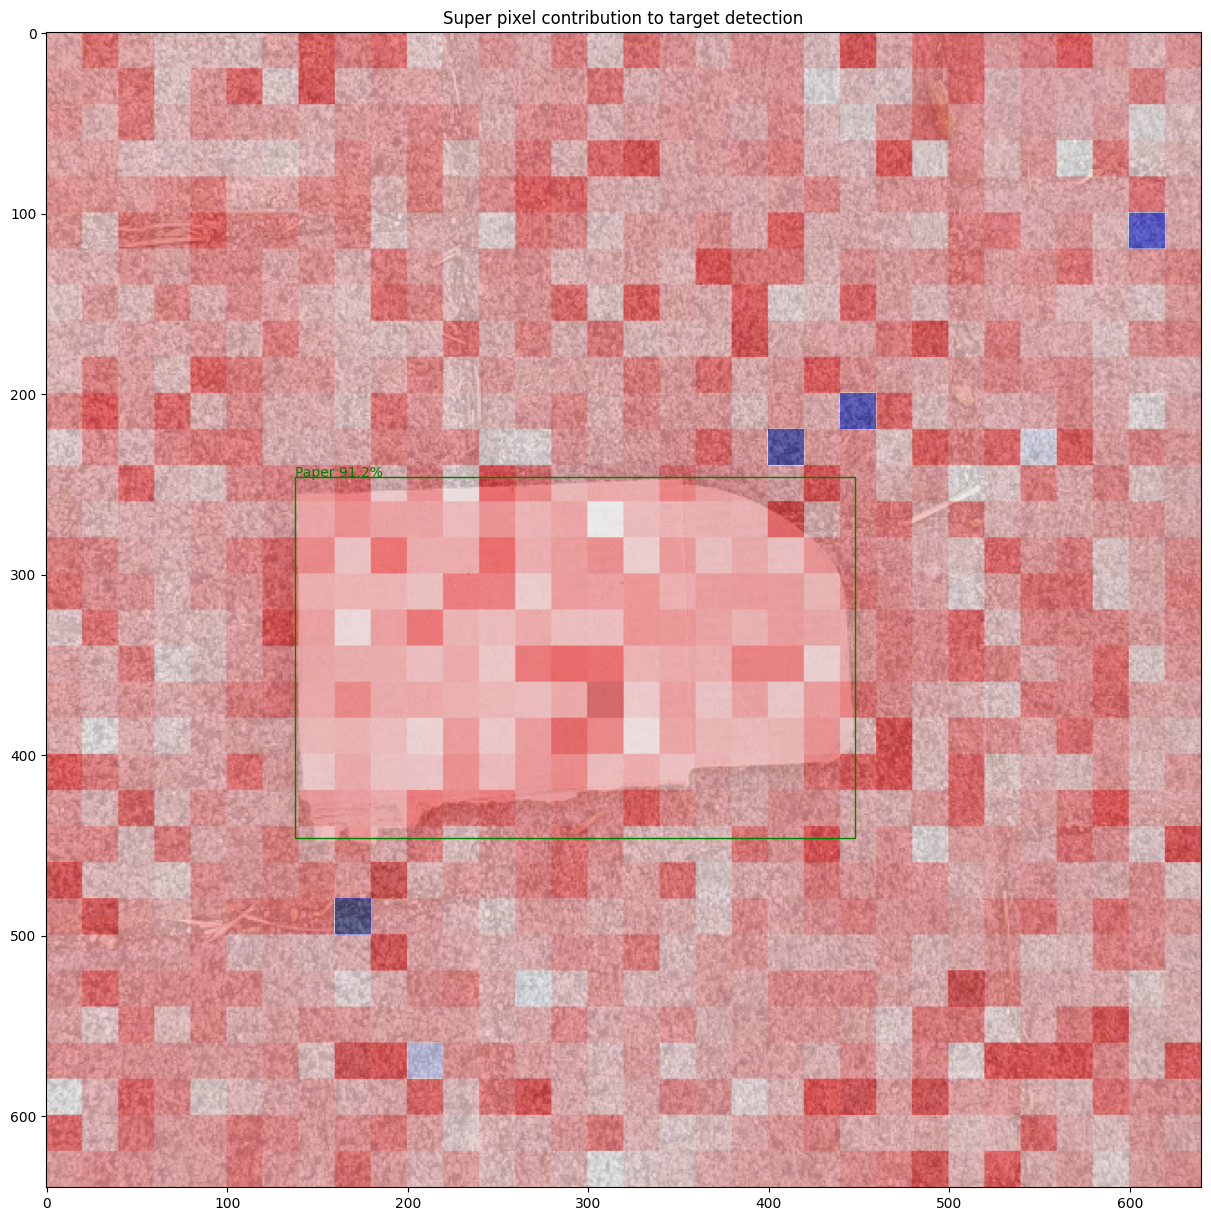

In [12]:
# plot image and shap values for super pixels on top
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_title("Super pixel contribution to target detection")
ax.imshow(img, alpha=0.7, cmap='gray', vmin=0, vmax=1)
ax.imshow(shap_to_pixel, cmap=plt.cm.seismic, vmin=0, vmax=1, alpha=0.5)

# Add bounding box of target
label = f"{model.names[int(target[5])]} {target[4]:0.1%}"
plt.text(target[0], target[1], label, color="green")
bbox = patches.Rectangle(target[:2], target[2]-target[0], target[3]-target[1], linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(bbox)
plt.show()